# Evaluate Multiple LLM Providers with LiteLLM



*   Quality Testing
*   Load Testing
*   Duration Testing



In [ ]:
!pip install litellm python-dotenv

In [ ]:
import litellm
from litellm import load_test_model, testing_batch_completion
import time

In [ ]:
from dotenv import load_dotenv
load_dotenv()

# Quality Test endpoint

## Test the same prompt across multiple LLM providers

In this example, let's ask some questions about Paul Graham

In [ ]:
models = ["gpt-3.5-turbo", "gpt-3.5-turbo-16k", "gpt-4", "claude-instant-1", "replicate/llama-2-70b-chat:58d078176e02c219e11eb4da5a02a7830a283b14cf8f94537af893ccff5ee781"]
context = """Paul Graham (/ɡræm/; born 1964)[3] is an English computer scientist, essayist, entrepreneur, venture capitalist, and author. He is best known for his work on the programming language Lisp, his former startup Viaweb (later renamed Yahoo! Store), cofounding the influential startup accelerator and seed capital firm Y Combinator, his essays, and Hacker News. He is the author of several computer programming books, including: On Lisp,[4] ANSI Common Lisp,[5] and Hackers & Painters.[6] Technology journalist Steven Levy has described Graham as a "hacker philosopher".[7] Graham was born in England, where he and his family maintain permanent residence. However he is also a citizen of the United States, where he was educated, lived, and worked until 2016."""
prompts = ["Who is Paul Graham?", "What is Paul Graham known for?" , "Is paul graham a writer?" , "Where does Paul Graham live?", "What has Paul Graham done?"]
messages =  [[{"role": "user", "content": context + "\n" + prompt}] for prompt in prompts] # pass in a list of messages we want to test
result = testing_batch_completion(models=models, messages=messages)

## Visualize the data

In [ ]:
import pandas as pd

# Create an empty list to store the row data
table_data = []

# Iterate through the list and extract the required data
for item in result:
    prompt = item['prompt'][0]['content'].replace(context, "") # clean the prompt for easy comparison
    model = item['response']['model']
    response = item['response']['choices'][0]['message']['content']
    table_data.append([prompt, model, response])

# Create a DataFrame from the table data
df = pd.DataFrame(table_data, columns=['Prompt', 'Model Name', 'Response'])

# Pivot the DataFrame to get the desired table format
table = df.pivot(index='Prompt', columns='Model Name', values='Response')
table

Model Name,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-16k-0613,gpt-4-0613,replicate/llama-2-70b-chat:58d078176e02c219e11eb4da5a02a7830a283b14cf8f94537af893ccff5ee781
Prompt,,,,,
\nIs paul graham a writer?,"Yes, Paul Graham is considered a writer in ad...","Yes, Paul Graham is a writer. He has written s...","Yes, Paul Graham is a writer. He has authored ...","Yes, Paul Graham is a writer. He is an essayis...","Yes, Paul Graham is an author. According to t..."
\nWhat has Paul Graham done?,Paul Graham has made significant contribution...,Paul Graham has achieved several notable accom...,Paul Graham has made significant contributions...,Paul Graham is known for his work on the progr...,Paul Graham has had a diverse career in compu...
\nWhat is Paul Graham known for?,Paul Graham is known for several things:\n\n-...,Paul Graham is known for his work on the progr...,Paul Graham is known for his work on the progr...,Paul Graham is known for his work on the progr...,"Paul Graham is known for many things, includi..."
\nWhere does Paul Graham live?,Based on the information provided:\n\n- Paul ...,"According to the given information, Paul Graha...","Paul Graham currently lives in England, where ...",The text does not provide a current place of r...,"Based on the information provided, Paul Graha..."
\nWho is Paul Graham?,Paul Graham is an influential computer scient...,"Paul Graham is an English computer scientist, ...","Paul Graham is an English computer scientist, ...","Paul Graham is an English computer scientist, ...","Paul Graham is an English computer scientist,..."


# Load Test endpoint

Run 100+ simultaneous queries across multiple providers to see when they fail + impact on latency

In [ ]:
models=["gpt-3.5-turbo", "replicate/llama-2-70b-chat:58d078176e02c219e11eb4da5a02a7830a283b14cf8f94537af893ccff5ee781", "claude-instant-1"]
context = """Paul Graham (/ɡræm/; born 1964)[3] is an English computer scientist, essayist, entrepreneur, venture capitalist, and author. He is best known for his work on the programming language Lisp, his former startup Viaweb (later renamed Yahoo! Store), cofounding the influential startup accelerator and seed capital firm Y Combinator, his essays, and Hacker News. He is the author of several computer programming books, including: On Lisp,[4] ANSI Common Lisp,[5] and Hackers & Painters.[6] Technology journalist Steven Levy has described Graham as a "hacker philosopher".[7] Graham was born in England, where he and his family maintain permanent residence. However he is also a citizen of the United States, where he was educated, lived, and worked until 2016."""
prompt = "Where does Paul Graham live?"
final_prompt = context + prompt
result = load_test_model(models=models, prompt=final_prompt, num_calls=5)

## Visualize the data

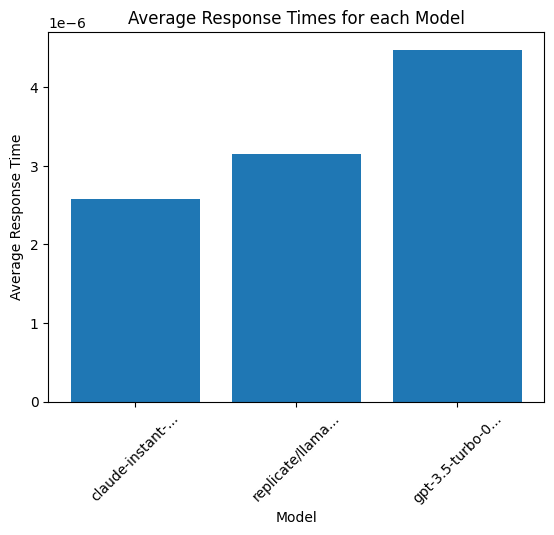

In [ ]:
import matplotlib.pyplot as plt

## calculate avg response time
unique_models = set(result["response"]['model'] for result in result["results"])
model_dict = {model: {"response_time": []} for model in unique_models}
for completion_result in result["results"]:
    model_dict[completion_result["response"]["model"]]["response_time"].append(completion_result["response_time"])

avg_response_time = {}
for model, data in model_dict.items():
    avg_response_time[model] = sum(data["response_time"]) / len(data["response_time"])

models = list(avg_response_time.keys())
response_times = list(avg_response_time.values())

plt.bar(models, response_times)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Average Response Time')
plt.title('Average Response Times for each Model')

plt.xticks(models, [model[:15]+'...' if len(model) > 15 else model for model in models], rotation=45)
plt.show()

# Duration Test endpoint

Run load testing for 2 mins. Hitting endpoints with 100+ queries every 15 seconds.

In [ ]:
models=["gpt-3.5-turbo", "replicate/llama-2-70b-chat:58d078176e02c219e11eb4da5a02a7830a283b14cf8f94537af893ccff5ee781", "claude-instant-1"]
context = """Paul Graham (/ɡræm/; born 1964)[3] is an English computer scientist, essayist, entrepreneur, venture capitalist, and author. He is best known for his work on the programming language Lisp, his former startup Viaweb (later renamed Yahoo! Store), cofounding the influential startup accelerator and seed capital firm Y Combinator, his essays, and Hacker News. He is the author of several computer programming books, including: On Lisp,[4] ANSI Common Lisp,[5] and Hackers & Painters.[6] Technology journalist Steven Levy has described Graham as a "hacker philosopher".[7] Graham was born in England, where he and his family maintain permanent residence. However he is also a citizen of the United States, where he was educated, lived, and worked until 2016."""
prompt = "Where does Paul Graham live?"
final_prompt = context + prompt
result = load_test_model(models=models, prompt=final_prompt, num_calls=100, interval=15, duration=120)

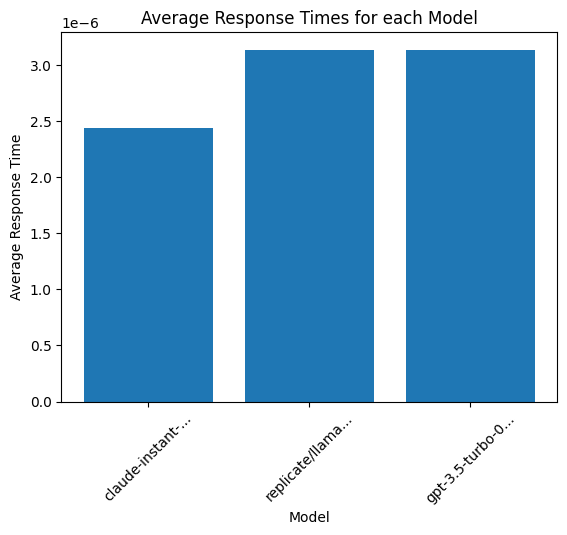

In [ ]:
import matplotlib.pyplot as plt

## calculate avg response time
unique_models = set(unique_result["response"]['model'] for unique_result in result[0]["results"])
model_dict = {model: {"response_time": []} for model in unique_models}
for iteration in result:
  for completion_result in iteration["results"]:
    model_dict[completion_result["response"]["model"]]["response_time"].append(completion_result["response_time"])

avg_response_time = {}
for model, data in model_dict.items():
    avg_response_time[model] = sum(data["response_time"]) / len(data["response_time"])

models = list(avg_response_time.keys())
response_times = list(avg_response_time.values())

plt.bar(models, response_times)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Average Response Time')
plt.title('Average Response Times for each Model')

plt.xticks(models, [model[:15]+'...' if len(model) > 15 else model for model in models], rotation=45)
plt.show()